In [6]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy.optimize
import scipy.stats
import scipy.interpolate
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from sklearn import tree
import copy
import calendar
#import seaborn as sns

#from optimise_GDD_fctns import Phenology_set, run_GDD_and_get_RMSE, run_GDD_and_get_RMSE_derivs, plot_profiles_at_minimum, get_station_locations, put_ERA5_in_array
import seaborn as sns

import xarray as xr
from xarray.backends import NetCDF4DataStore
import cartopy.crs as ccrs
from scipy.interpolate import griddata
import numpy.ma as ma
from pyproj import Proj, transform
import rioxarray
import geopandas

#from dwd_phenpy import Phenology_set

#import openeo
#import ee
## Trigger the authentication flow.
#ee.Authenticate()#(auth_mode='localhost')
# Initialize the library.
#ee.Initialize(project='ee-martinparker637')

In [2]:
ds_full = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\ERA5\\Kenya\\Kenya_ERA5_2000_2024.nc')

In [7]:
adm_data = geopandas.read_file('C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\KE_boundaries\\adm_boundaries.geojson')
adm_data = adm_data.loc[adm_data['name'] != 'Kenya']
adm_data = adm_data.loc[adm_data['unit_type'] == 'Admin 1']
adm_data.drop(columns = ['end_date', 'country_code', 
                         'fewsnet_region', 'geographic_group', 
                         'es_name', 'fr_name', 'pt_name',
                         'ar_name', 'country', 'admin_0',
                         'admin_3', 'admin_4', 'layer_id',
                         'geographicunitsetversion_name', 'zone_type', 'urban_rural', 'start_month',
                         ], inplace=True)
#adm_data = adm_data.explode()#.crs
adm_data.loc[:, 'centroid'] = adm_data.loc[:, 'geometry'].to_crs(crs=3857).centroid.to_crs('EPSG:4326')
adm_data_for_merging = adm_data.drop_duplicates(subset = ['admin_1']).drop(columns=['fnid', 'admin_2', 'start_date', 'id'])
yield_data = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\hvstat_africa_data.csv')
yield_data_mean = yield_data.loc[(yield_data['country'] == 'Kenya')].dropna()
yield_data_mean = yield_data_mean.loc[:, ['admin_1', 'yield']].groupby('admin_1').mean()
yield_data_mean = adm_data_for_merging.merge(yield_data_mean, left_on=['name'], right_on = ['admin_1'], how='right')

##### REMEMBER TO DO THE 1ST ONE #####
for region_index in list(range(21)) + list(range(22, 50)):
    print(region_index)
    adm1_name = yield_data_mean.iloc[region_index, 1]
    print(adm1_name)
    clipped = xds.rio.clip(yield_data_mean.iloc[[region_index], :].geometry.values, yield_data_mean.crs, all_touched = True, drop=True)#adm_data.iloc[10, :].geometry.exterior.coords
    clipped.to_netcdf(f'C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\ERA5\\Kenya\\vpd\\{adm1_name}_1999_2008.nc')

    #print(len(clipped.values[~np.isnan(clipped.values)]))
    #clipped2 = xds['t2m'].isel(time=10).rio.clip(yield_data_mean.iloc[[region_index], :].geometry.values, yield_data_mean.crs, all_touched = True, drop=False)#adm_data.iloc[10, :].geometry.exterior.coords
    #if len(clipped2.values[~np.isnan(clipped2.values)]) != len(clipped.values[~np.isnan(clipped.values)]):
    #    print(clipped2.values[~np.isnan(clipped2.values)])

Skipping field centroid: unsupported OGR type: 3


0
admin1


NameError: name 'xds' is not defined

In [17]:
def combine_years(savename, first_year, last_year):
    ds = xr.open_dataset(f'C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\ERA5\\{savename}_{first_year}.nc')
    for year in range(first_year + 1, last_year + 1):
        print(year)
        ds = xr.concat([ds, xr.open_dataset(f'C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\ERA5\\{savename}_{year}.nc')], dim='time')
    ds = ds.sortby('time')
    return ds

In [ ]:
ds_full = combine_years('Kenya\\Kenya_ERA5_daily', 2000, 2024)
ds_full.to_netcdf('C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\ERA5\\Kenya\\Kenya_ERA5_2000_2024.nc')

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024


In [ ]:
ds = combine_years('\\Germany_Pre_2000\\t2m_d2m\\ERA5_t2m_d2m', 1991, 2000)
ds_ssrd_tp = combine_years('\\Africa\\ssrd_tp\\ERA5_SSA_ssrd_tp', 1999, 2008)
ds = combine_years('\\Africa\\t2m_d2m\\ERA5_t2m_d2m_SSA', 1999, 2008)
def vapor_pressure(T):
    return 6.1094*xr.ufuncs.exp((17.625*T)/(T + 243.04))# August–Roche–Magnus 
ds['t2m'] += -273.15
ds['d2m'] += -273.15
sat_vp = 6.1094*xr.ufuncs.exp((ds['t2m'])/(ds['t2m'] + 243.04))
actual_vp = 6.1094*xr.ufuncs.exp((ds['d2m'])/(ds['d2m'] + 243.04))
ds['vpd'] = actual_vp - sat_vp #vapor_pressure(ds['d2m']) - vapor_pressure([ds['t2m']])
t2m = ds['t2m'].resample(time="1D").mean()
t2m.to_netcdf('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\Africa\\t2m_SSA_1999_2008.nc')
t2max = ds['t2m'].resample(time="1D").max()
t2max = t2max.rename('t2max')
t2min = ds['t2m'].resample(time="1D").min()
t2min = t2min.rename('t2min')
ds_for_driver = xr.merge([t2m, t2max, t2min, ds['vpd']])
ds_for_driver.to_netcdf('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\Germany_Pre_2000\\temp_vpd_DE_1991_2000.nc')
vpd = ds['vpd'].resample(time="1D").mean()
vpd.to_netcdf('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\Africa\\vpd_SSA_1999_2008.nc')
ds['vpd'].to_netcdf('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_DE_2001_2024_vpd.nc')

1992
1993
1994
1995
1996
1997
1998
1999
2000


In [ ]:
ds_for_solrad = ds_ssrd_tp.where((ds_ssrd_tp['time.hour'] > 5)*(ds_ssrd_tp['time.hour'] < 19), drop=True)
ssrd = ds_for_solrad['ssrd'].resample(time="1D").mean()
tp = ds_ssrd_tp['tp'].resample(time="1D").sum()
ds_for_driver = xr.merge([ssrd, tp])
ds_for_driver.to_netcdf('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\Germany_Pre_2000\\ssrd_tp_DE_1991_1999.nc')

In [2]:
hyras_data = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\tas_hyras_5_1951_2020_v5-0_de.nc').sel(time=slice('2000-01-01', '2020-12-31'))
hyras_data = hyras_data.drop(['x', 'y']).rename({'x': 'lon', 'y': 'lat'})
hyras_data= hyras_data.drop(['time_bnds', 'x_bnds', 'y_bnds'])
hyras_data= hyras_data.drop(['crs_HYRAS', 'number_of_stations'])
#hyras_data = hyras_data.rename({'y': 'lat', 'x': 'lon'})


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_19336\1752857012.py:2: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  hyras_data = hyras_data.drop(['x', 'y']).rename({'x': 'lon', 'y': 'lat'})
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_19336\1752857012.py:3: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  hyras_data= hyras_data.drop(['time_bnds', 'x_bnds', 'y_bnds'])
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_19336\1752857012.py:4: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  hyras_data= hyras_data.drop(['crs_HYRAS', 'number_of_stations'])


In [3]:
#ERA5_data = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\AGERA5\\VPD\\AGERA5_VPD_DE_2000.nc')#.sel(time=slice('2000-01-01', '2024-12-31'))
ERA5_data = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2011_2024.nc')
ERA5_data = ERA5_data.rename({'latitude': 'lat', 'longitude': 'lon'})

In [7]:
#ERA5_data.isel(time=710)['Vapour_Pressure_Mean_24h'].values

In [3]:
import os
os.environ['PROJ_DATA'] = "C:\\ProgramData\\anaconda3\\envs\\Data_Analysis_Revived\\Lib\\site-packages\\rasterio\\proj_data"
xds = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\tas_hyras_5_1951_2020_v5-0_de.nc', decode_coords="all").sel(time=slice('2000-01-01', '2020-12-31'))
xds = xds.rio.write_crs("EPSG:3035")
xds = xds.drop(['lon', 'lat'])
xds_lonlat = xds.rio.reproject("EPSG:4326")

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_24964\1201156179.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  xds = xds.drop(['lon', 'lat'])


In [ ]:
#ERA5_data['tas'] = hyras_data['tas'].interp(lat = ERA5_data['lat'], lon = ERA5_data['lon'])
ERA5_data['diff'] = ERA5_data['tas'] - ERA5_data['t2m']

In [4]:
hyras_data = hyras_data.where((hyras_data.time>np.datetime64('2012-01-01'))*(hyras_data.time<np.datetime64('2019-01-01')), drop = True)#dropna('time').mean(dim='time').plot()
ERA5_data = ERA5_data.where((ERA5_data.time>np.datetime64('2012-01-01'))*(ERA5_data.time<np.datetime64('2019-01-01')), drop = True)#dropna('time').mean(dim='time').plot()
hyras_data['time'] = hyras_data['time'] + np.timedelta64(-12, 'h')
hyras_data['t2m'] = ERA5_data['t2m'].interp(lat = hyras_data['lat'], lon = hyras_data['lon'])

In [9]:
#ERA5_data['t2m'].interp(lat = hyras_data['lat'], lon = hyras_data['lon']).mean(dim='time').plot()

In [10]:
#hyras_data['t2m'].max(dim='time').plot()

In [15]:
np.sqrt((hyras_data['diff']**2).mean(dim=['time', 'lat', 'lon'])).mean()

<xarray.DataArray 'diff' ()> Size: 8B
array(0.86501628)
Coordinates:
    number   int64 8B 0

(46.5, 55.0)

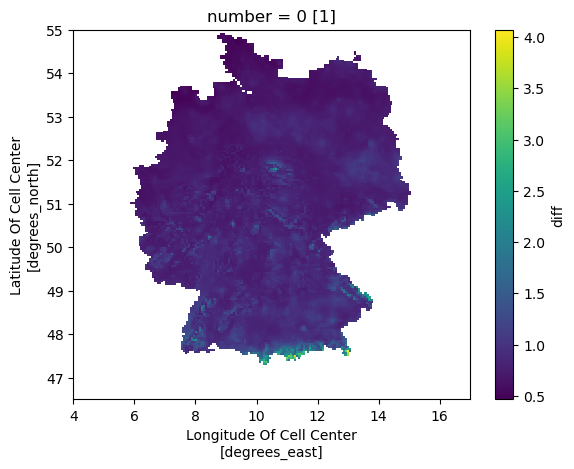

In [5]:
hyras_data['diff'] = hyras_data['tas'] - hyras_data['t2m']
fig, ax = plt.subplots()
#hyras_data['diff'].std(dim='time').plot(ax = ax)
np.sqrt((hyras_data['diff']**2).mean(dim='time')).plot(ax = ax)
ax.set_xlim((4, 17))
ax.set_ylim((46.5, 55))

In [62]:
hyras_data['diff'].std(dim='time').mean().values

array(0.75817584)

In [63]:
hyras_data['diff'].std().values

array(0.855429)

In [7]:
ds_station = pd.read_table('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\produkt_tu_stunde_20091201_20191231_00071.txt',
                           sep=';')
ds_station['MESS_DATUM'] = pd.to_datetime(ds_station['MESS_DATUM'], format='%Y%m%d%H')
ds_station = ds_station.drop(columns=['eor'])
ds_station = ds_station.set_index('MESS_DATUM').resample('D').mean()#['TT_TU'].plot()
#ds_station.loc[:, 't2m'] = ERA5_data['t2m'].interp(lat = 48.2156, lon = 8.9784).resample(time='D').mean().values
ERA5_at_stat = ERA5_data['t2m'].interp(lat = 48.2156, lon = 8.9784).drop(['number', 'lat', 'lon']).to_dataframe()
#ERA5_at_stat.merge(ds_station, left_on='time', right_on='MESS_DATUM')
compare = ERA5_at_stat.join(ds_station)
compare.loc[:, 'diff'] = (compare['t2m'] - compare['TT_TU'])**2

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_19336\1716901907.py:7: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ERA5_at_stat = ERA5_data['t2m'].interp(lat = 48.2156, lon = 8.9784).drop(['number', 'lat', 'lon']).to_dataframe()


In [11]:
np.sqrt(compare['diff'].mean())

np.float64(1.1329812768001077)

In [9]:
compare.reset_index().groupby(compare.reset_index()['time'].dt.dayofyear).mean()['diff'].mean()#.plot()

np.float64(1.2908064768832985)

In [98]:
np.sqrt((compare['diff'].std()**2)*2)

np.float64(1.323965413647687)

In [99]:
#ds_station.groupby(ds_station['MESS_DATUM'].dt.day).mean()

In [100]:
#hyras_data['t2m'].mean(dim='time').plot()

(45.0, 52.0)

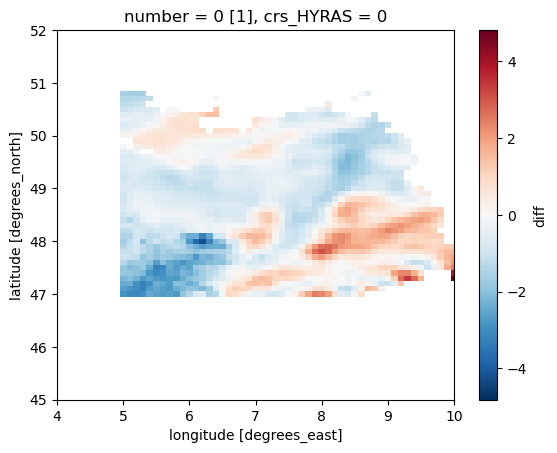

In [13]:
fig, ax = plt.subplots()
ERA5_data['diff'].mean(dim='time').plot(ax = ax)
ax.set_xlim((4, 10))
ax.set_ylim((45, 52))

In [56]:
hyras_averages = hyras_data.mean(dim='time')
ERA5_averages = ERA5_data.mean(dim='time')

In [57]:
hyras_averages['t2m'] = ERA5_averages['t2m'].interp(lat=hyras_averages['lat'], lon=hyras_averages['lon'])

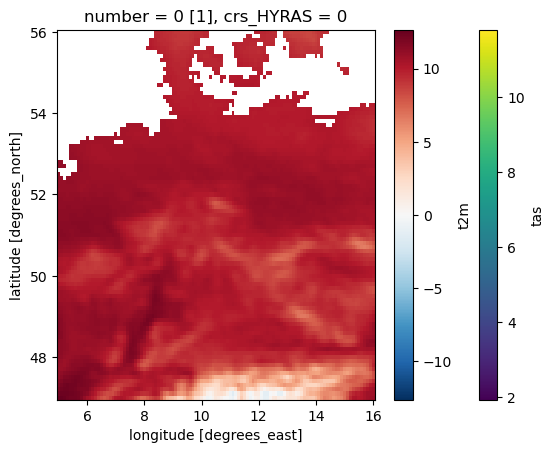

In [63]:
fig, ax = plt.subplots()
hyras_averages['tas'].plot(ax = ax)
ERA5_averages['t2m'].plot(ax = ax)

In [64]:
(ERA5_averages['t2m'] - hyras_averages['tas']).plot()

TypeError: No numeric data to plot.

In [28]:
#%conda activate
# Data_Analysis_Revived
#pyproj.datadir.set_data_dir("C:\\ProgramData\\anaconda3\\envs\\Data_Analysis_Revived\\Lib\\site-packages\\rasterio\\proj_data")


In [20]:
import pyproj
pyproj.datadir.get_data_dir()#"C:\ProgramData\anaconda3\envs\Data_Analysis_Revived\Lib\site-packages\rasterio\proj_data\proj.db")

'C:\\ProgramData\\anaconda3\\envs\\Data_Analysis_Revived\\Library\\share\\proj'

In [ ]:
"C:\ProgramData\anaconda3\envs\Data_Analysis_Revived\Lib\site-packages\rasterio\proj_data\proj.db"

In [ ]:
"C:\ProgramData\anaconda3\envs\Data_Analysis_Revived\Library\share\proj\proj.db"

In [15]:
hyras_data.crs_HYRAS

<xarray.DataArray 'crs_HYRAS' ()> Size: 4B
array(1)
Attributes: (12/16)
    grid_mapping_name:                  lambert_conformal_conic
    long_name:                          DWD HYRAS ETRS89 LCC grid with 240 co...
    standard_parallel:                  [35. 65.]
    longitude_of_central_meridian:      10.0
    latitude_of_projection_origin:      52.0
    semi_major_axis:                    6378137.0
    ...                                 ...
    scale_factor_at_projection_origin:  0.017453292519943295
    proj4:                              +proj=lcc +lat_1=35 +lat_2=65 +lat_0=...
    proj4_params:                       +proj=lcc +lat_1=35 +lat_2=65 +lat_0=...
    epsg_code:                          EPSG:3034
    crs_wkt:                            PROJCS["ETRS_1989_LCC",GEOGCS["GCS_ET...
    spatial_ref:                        PROJCS["ETRS_1989_LCC",GEOGCS["GCS_ET...

In [18]:
hd = hyras_data['tas'].coarsen(lon=4).std().coarsen(lat=4).std()

c:\ProgramData\anaconda3\envs\Data_Analysis_Revived\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\ProgramData\anaconda3\envs\Data_Analysis_Revived\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [22]:
hd.isel(lon=25, lat = 25)

<xarray.DataArray 'tas' (time: 7671)> Size: 31kB
array([0.05299022, 0.06848152, 0.07651997, ..., 0.05393928, 0.06201186,
       0.06041406], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 61kB 2000-01-01T12:00:00 ... 2020-12-31T12...
    lon      float64 8B 10.15
    lat      float64 8B 50.23
Attributes:
    standard_name:      air_temperature
    long_name:          Daily Mean Air Temperature
    units:              Celsius
    grid_mapping:       crs_HYRAS
    cell_methods:       time: mean
    CoordinateSystems:  LatLonCoordinateSystem ProjectionCoordinateSystem
    esri_pe_string:     PROJCS["ETRS_1989_LCC",GEOGCS["GCS_ETRS_1989",DATUM["...

In [13]:
ERA5_data_t2m = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2020.nc')
ERA5_data_skin = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\Germany Skin\\ERA5_skin_DE_2020.nc')
ds_t2m = ERA5_data_t2m.rename({'valid_time':'time', 'latitude':'lat', 'longitude':'lon'})
ds_skin = ERA5_data_skin.rename({'valid_time':'time', 'latitude':'lat', 'longitude':'lon'})
#ds = ds.sortby('time')
t2m = ds_t2m['t2m'].resample(time="1D").mean()
skin = ds_skin['skt'].resample(time="1D").mean()

In [74]:
np.sqrt(2*(0.8**2))

np.float64(1.1313708498984762)

In [27]:
0.8**2 + 1.1**2

1.8500000000000003

In [14]:
t2m['skt'] = skin

In [25]:
t2m['diff'] = (t2m.values - t2m['skt'])**2

In [26]:
np.sqrt(t2m['diff'].mean(dim=['time', 'lat', 'lon']))#.plot(vmax = 1, vmin = 0)#vmin = -1, vmax = 1, cmap = 'coolwarm')

<xarray.DataArray 'diff' ()> Size: 4B
array(0.85304284, dtype=float32)
Coordinates:
    number   int64 8B ...

In [56]:
skin = ds_skin['skt'].resample(time="1D").mean()

In [79]:
ERA5_data_t2m = ERA5_data_t2m.rename({'valid_time': 'time'})

In [80]:
tmax = ERA5_data_t2m['t2m'].resample(time="1D").max()
tmin = ERA5_data_t2m['t2m'].resample(time="1D").min()

In [84]:
diffmean = (tmax - tmin).std(dim = ['time', 'latitude', 'longitude'])

In [18]:
hyras_lon = hyras_data.lon.values
hyras_lat = hyras_data.lat.values
ERA5_lon = ERA5_data.lon.values
ERA5_lat = ERA5_data.lat.values
#hyras_LON, hyras_LAT = np.meshgrid(hyras_lon, hyras_lat)
ERA5_LON, ERA5_LAT = np.meshgrid(ERA5_lon, ERA5_lat)


In [45]:
ERA5_data['t2m mean'] = ERA5_data.t2m.mean(dim='time')
hyras_data['ERA5 t2m'] = (('time', 'lat', 'lon'), np.zeros(hyras_data.tas.values.shape))
interpolated_temps = []
for year in range(2011, 2020):
    if year % 4 == 0:
        numdays = 366
    else:
        numdays = 365
    for day in range(numdays):#366
        date = np.datetime64(f'{year}-01-01') + np.timedelta64(day, 'D')
        print(date)
        ERA5_interpolator = scipy.interpolate.RegularGridInterpolator((ERA5_lat, ERA5_lon), ERA5_data.t2m.sel(time=date).values, method='linear', bounds_error=False, fill_value=None)
        interpolated_temps.append(ERA5_interpolator((hyras_lat, hyras_lon)))

hyras_data['ERA5 t2m'] = (('time', 'lat', 'lon'), np.array(interpolated_temps))#ERA5_interpolator((hyras_lat, hyras_lon))#hyras_data.assign({'ERA5 t2m':(('lat', 'lon'), ERA5_interpolator((hyras_lat, hyras_lon)))})

2011-01-01
2011-01-02
2011-01-03
2011-01-04
2011-01-05
2011-01-06
2011-01-07
2011-01-08
2011-01-09
2011-01-10
2011-01-11
2011-01-12
2011-01-13
2011-01-14
2011-01-15
2011-01-16
2011-01-17
2011-01-18
2011-01-19
2011-01-20
2011-01-21
2011-01-22
2011-01-23
2011-01-24
2011-01-25
2011-01-26
2011-01-27
2011-01-28
2011-01-29
2011-01-30
2011-01-31
2011-02-01
2011-02-02
2011-02-03
2011-02-04
2011-02-05
2011-02-06
2011-02-07
2011-02-08
2011-02-09
2011-02-10
2011-02-11
2011-02-12
2011-02-13
2011-02-14
2011-02-15
2011-02-16
2011-02-17
2011-02-18
2011-02-19
2011-02-20
2011-02-21
2011-02-22
2011-02-23
2011-02-24
2011-02-25
2011-02-26
2011-02-27
2011-02-28
2011-03-01
2011-03-02
2011-03-03
2011-03-04
2011-03-05
2011-03-06
2011-03-07
2011-03-08
2011-03-09
2011-03-10
2011-03-11
2011-03-12
2011-03-13
2011-03-14
2011-03-15
2011-03-16
2011-03-17
2011-03-18
2011-03-19
2011-03-20
2011-03-21
2011-03-22
2011-03-23
2011-03-24
2011-03-25
2011-03-26
2011-03-27
2011-03-28
2011-03-29
2011-03-30
2011-03-31
2011-04-01

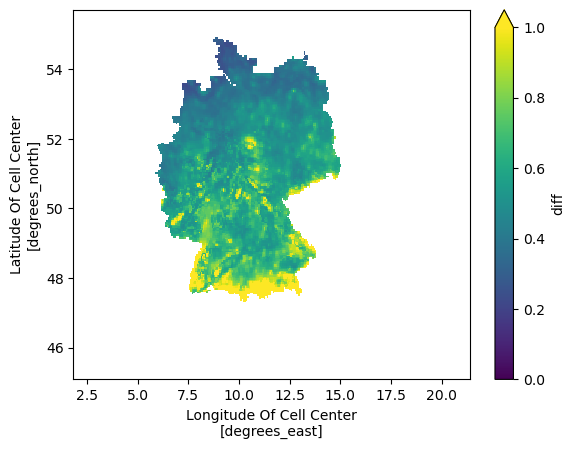

In [68]:
fig, ax = plt.subplots()
hyras_data['diff'].sel(time=slice('2000-01-01', '2020-12-31')).var(dim='time').plot(ax=ax, vmax = 1, vmin = 0)

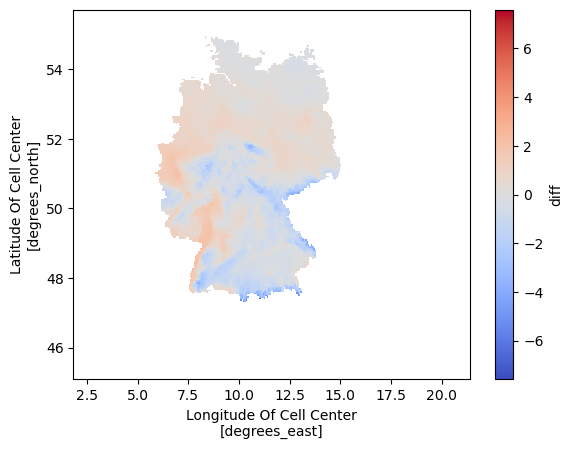

In [46]:
(meandiff - meandiff.mean()).plot(cmap = 'coolwarm')

In [ ]:
ds_inputs_DE1 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_2001_2024.csv')
#ds_inputs_DE.loc[:, [f'temperature at day {n}' for n in range(200)]] = modelling_fctns.Wang_Engel_Temp_response(ds_inputs_DE.loc[:, [f'temperature at day {n}' for n in range(200)]], 7, 28, 42)
ds_inputs_DE1=ds_inputs_DE1.rename(columns={'Referenzjahr':'year'})
print(len(ds_inputs_DE1))
ds_inputs_DE1 = ds_inputs_DE1.dropna(how='all')
print(len(ds_inputs_DE1))
ds_inputs_DE1 = ds_inputs_DE1.loc[ds_inputs_DE1['observed time to beginning of flowering'] < 200]
ds_inputs_DE1 = ds_inputs_DE1.loc[ds_inputs_DE1['observed time to beginning of flowering'] > 40]
ds_inputs_DE2 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_90s.csv')
ds_inputs_DE2=ds_inputs_DE2.rename(columns={'Referenzjahr':'year'})
ds_inputs_DE = pd.concat([ds_inputs_DE1, ds_inputs_DE2], ignore_index=True).drop_duplicates()
ds_inputs_DE = ds_inputs_DE.rename(columns = {f't2m at day {n}': f'temperature at day {n}' for n in range(300)})
ds_inputs_DE = ds_inputs_DE.rename(columns = {'year': 'Referenzjahr'})
ds_inputs_DE['observed time to beginning of flowering'] = pd.to_timedelta(ds_inputs_DE['observed time to beginning of flowering'], 'D')#, 'D'
FAO_sorts_string = ds_inputs_DE['SORTE'].str.split(' ').str.get(-1)
FAO_sorts_string = FAO_sorts_string*(1 - FAO_sorts_string.str.contains(r'[a-zA-Z]', regex=True))
FAO_sorts_string.replace('', np.nan, inplace = True)
FAO_sorts_string.fillna(0, inplace=True)
FAO_sorts_string = FAO_sorts_string.astype(np.int64)
ds_inputs_DE['FAO_sort'] = FAO_sorts_string
ds_inputs_DE['FAO_sort'].unique()
print(len(ds_inputs_DE['FAO_sort']), len(ds_inputs_DE['FAO_sort'].dropna()))
ds_inputs_DE.loc[ds_inputs_DE['FAO_sort'] == 0, 'FAO_sort'] = (ds_inputs_DE.loc[ds_inputs_DE['FAO_sort'] == 0, 'SILOREIFEZAHL'] + ds_inputs_DE.loc[ds_inputs_DE['FAO_sort'] == 0, 'KOERNERREIFEZAHL'])/2
early_threshold = 220
ei_threshold = 225
il_threshold = 250
ds_inputs_DE_early = ds_inputs_DE.loc[(ds_inputs_DE['FAO_sort'] > 0)*(ds_inputs_DE['FAO_sort'] < early_threshold)]
print(len(ds_inputs_DE_early))
ds_inputs_DE_ei = ds_inputs_DE.loc[(ds_inputs_DE['FAO_sort'] >= early_threshold)*(ds_inputs_DE['FAO_sort'] <= ei_threshold)]
print(len(ds_inputs_DE_ei))
ds_inputs_DE_il = ds_inputs_DE.loc[(ds_inputs_DE['FAO_sort'] > ei_threshold)*(ds_inputs_DE['FAO_sort'] < il_threshold)]
print(len(ds_inputs_DE_il))
ds_inputs_DE_late = ds_inputs_DE.loc[(ds_inputs_DE['FAO_sort'] >= il_threshold)]
print(len(ds_inputs_DE_late))

15308
15308
26208 26208
2803
3492
4434
3161


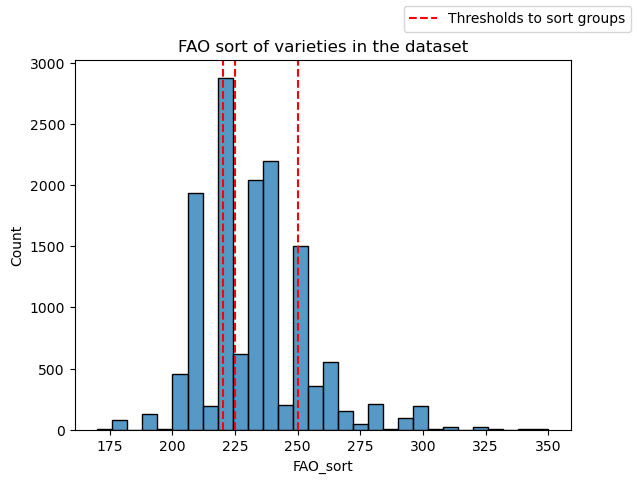

In [39]:
fig, ax = plt.subplots()
sns.histplot(ds_inputs_DE['FAO_sort'], ax = ax, bins = 30)
ax.set_title('FAO sort of varieties in the dataset')
ax.axvline(early_threshold, color = 'red', linestyle = '--', label = 'Thresholds to sort groups')
ax.axvline(ei_threshold, color = 'red', linestyle = '--')
ax.axvline(il_threshold, color = 'red', linestyle = '--')
fig.legend()

In [ ]:
ds_inputs_DE_early.loc[:, 'sort bin'] = 'Early'
ds_inputs_DE_ei.loc[:, 'sort bin'] = 'Early-intermediate'
ds_inputs_DE_il.loc[:, 'sort bin'] = 'Intermediate-late'
ds_inputs_DE_late.loc[:, 'sort bin'] = 'Late'
ds_inputs_DE_named = pd.concat([ds_inputs_DE_early, ds_inputs_DE_ei, ds_inputs_DE_il, ds_inputs_DE_late], ignore_index=True)

In [41]:
ds_inputs_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\SSA_ML_ERA5_1999_2008_with_varieties.csv')
ds_inputs_SSA = ds_inputs_SSA.rename(columns = {f't2m at day {n}': f'temperature at day {n}' for n in range(300)})
ds_inputs_SSA = ds_inputs_SSA.rename(columns = {'year': 'Referenzjahr'})
ds_inputs_SSA = ds_inputs_SSA.loc[ds_inputs_SSA['observed time to beginning of flowering'] < 200]
ds_inputs_SSA = ds_inputs_SSA.loc[ds_inputs_SSA['observed time to beginning of flowering'] > 30]
ds_inputs_SSA['observed time to beginning of flowering'] = pd.to_timedelta(ds_inputs_SSA['observed time to beginning of flowering'], 'D')


In [44]:
ds_inputs_SSA.loc[ds_inputs_SSA['Management'] == 'Drought'].drop_duplicates(subset = ['lat', 'lon'])

,Unnamed: 0.1,Unnamed: 0,WC SOS date,Stations_id,lat,lon,Management,vargroup,Referenzjahr,temperature at day 0,...,photoperiod at day 160,photoperiod at day 161,photoperiod at day 162,photoperiod at day 163,photoperiod at day 164,photoperiod at day 165,photoperiod at day 166,photoperiod at day 167,photoperiod at day 168,photoperiod at day 169
46,46,46,2003-06-18,15,-9.1000,13.7000,Drought,EPOP,2003,24.656342,...,12.583333,12.583333,12.600000,12.583333,12.600000,12.600000,12.616667,12.616667,12.616667,12.616667
59,59,60,2002-12-24,77,-25.4800,25.4700,Drought,EIHY,2003,26.950370,...,10.650000,10.633333,10.633333,10.616667,10.600000,10.600000,10.583333,10.583333,10.583333,10.566667
68,68,69,2001-02-01,78,-24.0000,21.8000,Drought,EPOP,2001,26.252258,...,10.750000,10.750000,10.766667,10.783333,10.783333,10.800000,10.800000,10.833333,10.833333,10.850000
77,77,78,2002-12-21,81,-24.5700,25.9500,Drought,EIHY,2003,26.667615,...,10.733333,10.716667,10.716667,10.716667,10.700000,10.683333,10.666667,10.666667,10.666667,10.650000
161,161,163,2001-06-02,530,-13.1300,34.0700,Drought,EIHY,2001,19.536587,...,12.666667,12.666667,12.683333,12.700000,12.700000,12.716667,12.716667,12.733333,12.733333,12.750000
223,223,225,2003-05-22,538,-13.7500,34.5800,Drought,ILPO,2003,22.873804,...,12.550000,12.583333,12.583333,12.583333,12.616667,12.616667,12.616667,12.650000,12.650000,12.650000
244,244,246,2002-11-22,726,-24.5300,33.0000,Drought,EIHY,2003,25.308917,...,11.183333,11.166667,11.166667,11.133333,11.116667,11.100000,11.083333,11.050000,11.050000,11.016667
254,254,256,2002-12-23,736,-15.1000,39.2800,Drought,EIHY,2003,24.655212,...,11.300000,11.283333,11.283333,11.283333,11.266667,11.266667,11.266667,11.250000,11.250000,11.250000
288,288,290,2003-12-04,864,-25.7900,31.0600,Drought,EPOP,2004,19.016467,...,10.916667,10.883333,10.883333,10.850000,10.850000,10.816667,10.816667,10.783333,10.783333,10.766667
292,292,294,2000-12-04,881,-25.4700,30.9700,Drought,EPOP,2001,19.378466,...,10.916667,10.900000,10.883333,10.866667,10.850000,10.833333,10.800000,10.800000,10.783333,10.766667


Text(0.5, 1.0, 'Distribution of varieties in the dataset by year and FAO number')

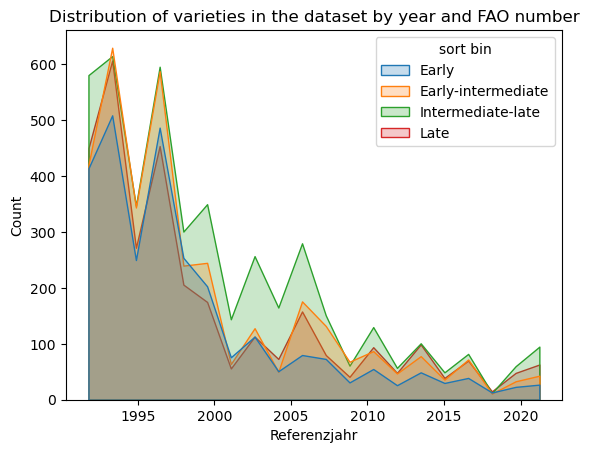

In [33]:
fig, ax = plt.subplots()
sns.histplot(data=ds_inputs_DE_named, x="Referenzjahr", hue="sort bin", bins = 20, element = 'poly')#, shrink=.8)
ax.set_title('Distribution of varieties in the dataset by year and FAO number')
#sns.barplot(data=ds_inputs_DE_named, x='Referenzjahr', y='observed time to beginning of flowering', hue='sort bin', ci=None, palette='Set1')

In [13]:
ds_inputs_DE_named['Referenzjahr'].unique()

array([2005, 2021, 2002, 2006, 2003, 2015, 2007, 2008, 2017, 2001, 2010,
       2011, 2012, 2020, 2022, 2004, 2013, 2014, 2009, 2019, 2016, 2018,
       1992, 1993, 1994, 1995, 1996, 1998, 1999, 1997, 1991])

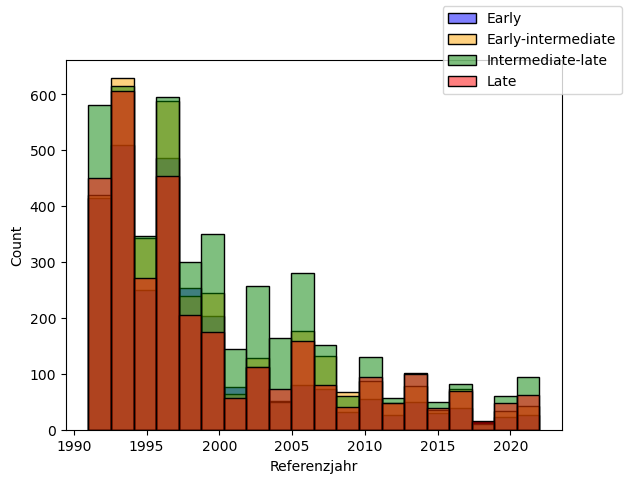

In [5]:
fig, ax = plt.subplots()
sns.histplot(ds_inputs_DE_early['Referenzjahr'], ax=ax, bins=20, color='blue', label='Early', alpha=0.5)
sns.histplot(ds_inputs_DE_ei['Referenzjahr'], ax=ax, bins=20, color='orange', label='Early-intermediate', alpha=0.5)
sns.histplot(ds_inputs_DE_il['Referenzjahr'], ax=ax, bins=20, color='green', label='Intermediate-late', alpha=0.5)
sns.histplot(ds_inputs_DE_late['Referenzjahr'], ax=ax, bins=20, color='red', label='Late', alpha=0.5)
fig.legend(loc='upper right')

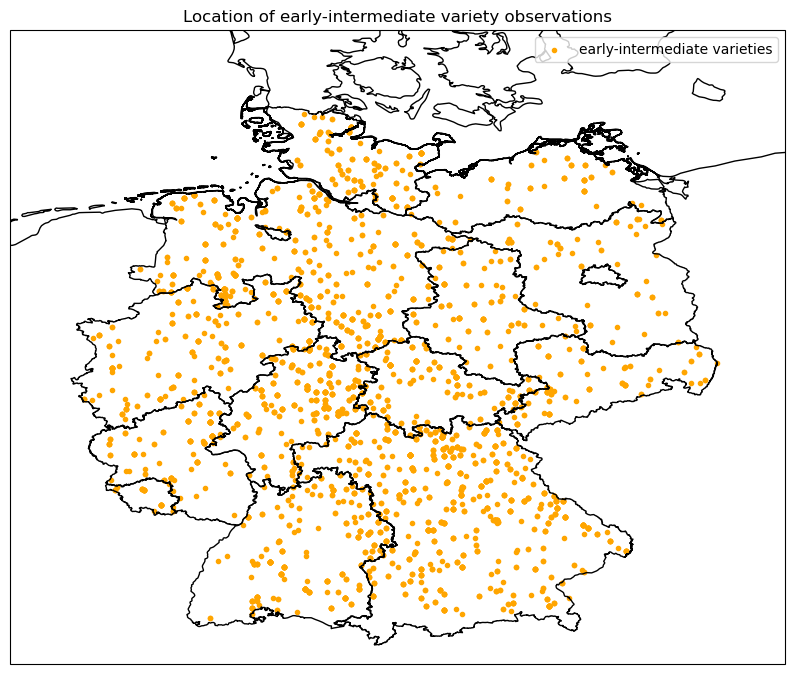

In [36]:
fig, ax = plotting.Germany_plot()
#temp_map = ERA5_data['t2m'].mean(dim='time').plot(cmap = 'Reds', ax=ax, vmin = 4)
ax.set_title('Location of early-intermediate variety observations')

#ax.scatter(ds_inputs_DE_early['lon'], ds_inputs_DE_early['lat'], color = 'green', marker='x', label='early varieties')
ax.scatter(ds_inputs_DE_ei['lon'], ds_inputs_DE_ei['lat'], color = 'orange', marker='.', label='early-intermediate varieties')
#ax.scatter(ds_inputs_DE_il['lon'], ds_inputs_DE_il['lat'], color = 'blue', marker='o', label='intermediate-late varieties')
#ax.scatter(ds_inputs_DE_late['lon'], ds_inputs_DE_late['lat'], color = 'black', marker='v', label='late varieties')
ax.legend()

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_18068\487062330.py:19: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')


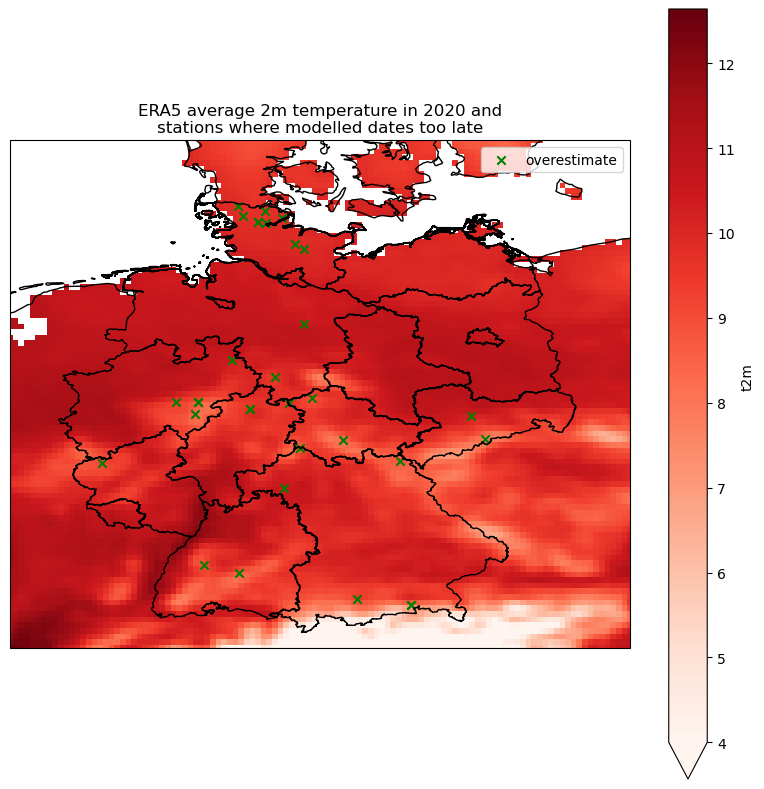

In [16]:
fig, ax = plotting.Germany_plot()
#stat_locs = pd.read_csv('Saved_files/canm_latlon3.csv')
bf_locs = pd.read_csv('Saved_files/cabf_latlon.csv')#3
lm_locs = pd.read_csv('Saved_files/calm_latlon.csv')#3
#for year_index, year in enumerate(stat_locs['Referenzjahr'].unique()):
#    stat_locs_year = stat_locs.where(stat_locs['Referenzjahr'] == year).dropna()
#    ax.scatter(stat_locs_year['lon'], stat_locs_year['lat'], label=year, color = ['r', 'g', 'b', 'k', 'purple', 'orange', 'yellow'][year_index])#, 'ro', transform=ccrs.PlateCarree())
#stat_locs = stat_locs.where(stat_locs['Referenzjahr'] == 2004).dropna()
#, 'ro', transform=ccrs.PlateCarree())
#hyras_data['tas'].mean(dim='time').plot(cmap = 'Reds', ax=ax)#std(dim='time').plot(vmax=1)#.plot(vmin = -1, vmax = 1, cmap = 'coolwarm')#.isel(time=150)vmin = 0, vmax = 20, 
temp_map = ERA5_data['t2m'].mean(dim='time').plot(cmap = 'Reds', ax=ax, vmin = 4)
#temp_map = ERA5_ge_10['t2m'].plot(cmap = 'Reds', ax=ax, vmin = 4)
ax.set_title('ERA5 average 2m temperature in 2020 and\nstations where modelled dates too late')
#plt.colorbar(temp_map, label='Temperature (°C)')
#hyras_data['diff'].mean(dim='time').plot(cmap = 'coolwarm', ax=ax, vmin = -1, vmax = 1)
#ax.scatter(stat_locs['lon'], stat_locs['lat'], color = 'green', marker='x', label='Didn\'t mature')
#ax.scatter(lm_locs['lon'], lm_locs['lat'], color = 'purple', marker='+', label='Modelled maturity\ntoo late')
#ax.scatter(bf_locs['lon'], bf_locs['lat'], color = 'blue', marker='.', label='Modelled flowering\ntoo late')
station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')
#overestimate = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\late_flowering.csv')
overestimate = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ca_late_pred.csv')
#overestimate = get_station_locations(overestimate, station_data)
#underestimate = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\underestimate.csv')
#underestimate = get_station_locations(underestimate, station_data)
#long_fitted = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\long_fitted.csv')
#long_fitted = get_station_locations(long_fitted, station_data)
#ax.scatter(underestimate['lon'], underestimate['lat'], color = 'purple', marker='+', label='underestimate')
ax.scatter(overestimate['lon'], overestimate['lat'], color = 'green', marker='x', label='overestimate')
#ax.scatter(long_fitted['lon'], long_fitted['lat'], color = 'blue', marker='.', label='long_fitted')
ax.legend()

In [15]:
overestimate

,Unnamed: 0.1,Unnamed: 0,Planting date,Referenzjahr,Stations_id,lat,lon,Objekt_id,Reporting method,Historic or recent,...,photoperiod at day 161,photoperiod at day 162,photoperiod at day 163,photoperiod at day 164,photoperiod at day 165,photoperiod at day 166,photoperiod at day 167,photoperiod at day 168,photoperiod at day 169,modelled time to beginning of flowering
0,13164,68695,2004-04-22,2004,13589,51.2167,11.0833,215,annual,historic,...,11.683333,11.616667,11.566667,11.483333,11.416667,11.366667,11.300000,11.216667,11.166667,101.0
1,13535,71159,2014-04-07,2014,13930,50.3500,8.1667,215,annual,historic,...,12.666667,12.616667,12.533333,12.483333,12.416667,12.366667,12.283333,12.233333,12.166667,101.0
2,2008,12726,2020-04-25,2020,8535,53.6500,7.6167,215,annual,historic,...,11.450000,11.366667,11.300000,11.233333,11.150000,11.100000,11.016667,10.950000,10.883333,101.0
3,13745,72832,2020-04-10,2020,14252,50.2556,10.9622,210,immediate,historic,...,12.450000,12.400000,12.333333,12.266667,12.200000,12.150000,12.083333,12.000000,11.950000,101.0
4,3381,19430,2020-04-10,2020,9241,51.3500,7.9500,210,immediate,historic,...,12.466667,12.400000,12.333333,12.283333,12.200000,12.150000,12.083333,12.000000,11.950000,109.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,98,1103,2020-04-14,2020,7623,54.6667,9.1333,215,annual,historic,...,12.216667,12.166667,12.083333,12.000000,11.933333,11.850000,11.783333,11.700000,11.650000,113.0
275,13309,69549,2009-04-16,2009,13635,51.4000,10.4833,215,annual,historic,...,12.083333,12.033333,11.950000,11.900000,11.833333,11.750000,11.700000,11.633333,11.550000,110.0
276,13795,73196,2020-04-17,2020,14434,54.2500,9.7000,215,annual,historic,...,12.000000,11.933333,11.866667,11.800000,11.716667,11.650000,11.566667,11.500000,11.433333,106.0
277,14070,75196,2010-04-21,2010,15252,51.0219,10.5158,210,immediate,historic,...,11.783333,11.716667,11.650000,11.583333,11.533333,11.466667,11.383333,11.333333,11.266667,102.0


In [65]:
hyras_interpolator = scipy.interpolate.RegularGridInterpolator((hyras_lat, hyras_lon), hyras_data.tas.values, method='linear', bounds_error=False, fill_value=None)

ValueError: The points in dimension 1 must be strictly ascending or descending

In [45]:
ERA5_data.lat.sortby('lat')

<xarray.DataArray 'lat' (lat: 91)> Size: 728B
array([47. , 47.1, 47.2, 47.3, 47.4, 47.5, 47.6, 47.7, 47.8, 47.9, 48. , 48.1,
       48.2, 48.3, 48.4, 48.5, 48.6, 48.7, 48.8, 48.9, 49. , 49.1, 49.2, 49.3,
       49.4, 49.5, 49.6, 49.7, 49.8, 49.9, 50. , 50.1, 50.2, 50.3, 50.4, 50.5,
       50.6, 50.7, 50.8, 50.9, 51. , 51.1, 51.2, 51.3, 51.4, 51.5, 51.6, 51.7,
       51.8, 51.9, 52. , 52.1, 52.2, 52.3, 52.4, 52.5, 52.6, 52.7, 52.8, 52.9,
       53. , 53.1, 53.2, 53.3, 53.4, 53.5, 53.6, 53.7, 53.8, 53.9, 54. , 54.1,
       54.2, 54.3, 54.4, 54.5, 54.6, 54.7, 54.8, 54.9, 55. , 55.1, 55.2, 55.3,
       55.4, 55.5, 55.6, 55.7, 55.8, 55.9, 56. ])
Coordinates:
    number   int64 8B ...
  * lat      (lat) float64 728B 47.0 47.1 47.2 47.3 47.4 ... 55.7 55.8 55.9 56.0
Attributes:
    units:             degrees_north
    standard_name:     latitude
    long_name:         latitude
    stored_direction:  decreasing

In [61]:
hyras_data.reindex({'lat':ERA5_data.lat, 'lon':ERA5_data.lon}, method='nearest')

ValueError: cannot reindex or align along dimension 'lat' because of conflicting dimension sizes: {91, 220} (note: an index is found along that dimension with size=91)

In [60]:
hyras_data.interp_like(ERA5_data)#({'lat':ERA5_data.lat.sortby('lat').values, 'lon':ERA5_data.lon.sortby('lon').values},method='nearest')# 'time':np.datetime64('2020-05-19')}, method='nearest')

ValueError: Input DataArray is not 1-D.

In [27]:
hyras_data.reindex(lat=ERA5_data['lat'], lon=ERA5_data['lon'], method='nearest')

<xarray.Dataset> Size: 78MB
Dimensions:             (time: 366, bnds: 2, y: 220, x: 240)
Coordinates:
  * time                (time) datetime64[ns] 3kB 2020-01-01T12:00:00 ... 202...
    lon                 (y, x) float64 422kB ...
    lat                 (y, x) float64 422kB ...
  * x                   (x) float32 960B 3.502e+06 3.508e+06 ... 4.698e+06
  * y                   (y) float32 880B 2.102e+06 2.108e+06 ... 3.198e+06
Dimensions without coordinates: bnds
Data variables:
    time_bnds           (time, bnds) datetime64[ns] 6kB ...
    x_bnds              (x, bnds) float32 2kB ...
    y_bnds              (y, bnds) float32 2kB ...
    crs_HYRAS           int32 4B ...
    tas                 (time, y, x) float32 77MB ...
    number_of_stations  (time) float64 3kB ...
Attributes: (12/19)
    source:                 surface observations
    Conventions:            CF-1.8
    realization:            v5.0
    project_id:             HYRAS
    input_data_status:      non-realtime
    level_type:             surface
    ...                     ...
    horizontal_resolution:  5 km
    title:                  gridded_temperature_dataset_(HYRAS-DE TAS)
    institution:            Deutscher Wetterdienst (DWD)
    creation_date:          created at 2022-12-04 13:12:56
    filename:               tas_hyras_5_1951_2020_v5-0_de.nc
    unique_dataset_id:      DWD_HYRAS_DE_tas_v5.0_1951_2020_day_00638C9CD8

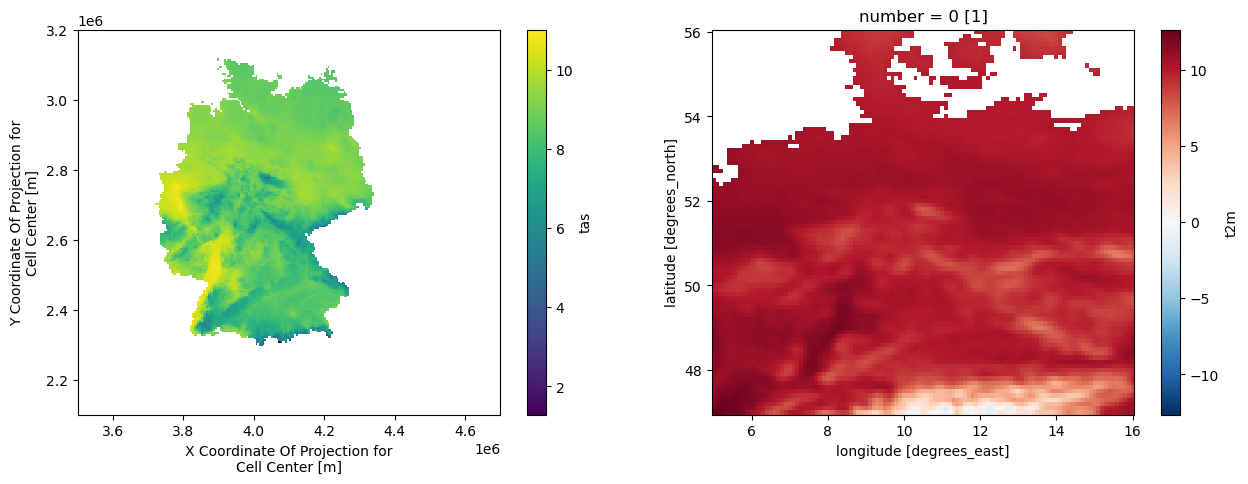

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
hyras_data['tas'].mean(dim='time').plot(ax=axs[0])
ERA5_data['t2m'].mean(dim='time').plot(ax=axs[1])

In [11]:
stat_locs['Referenzjahr'].unique()

array([2004., 2010., 2012., 2015., 2011., 2014., 2007., 2002., 2008.,
       2020., 2016.])

IndexError: list index out of range

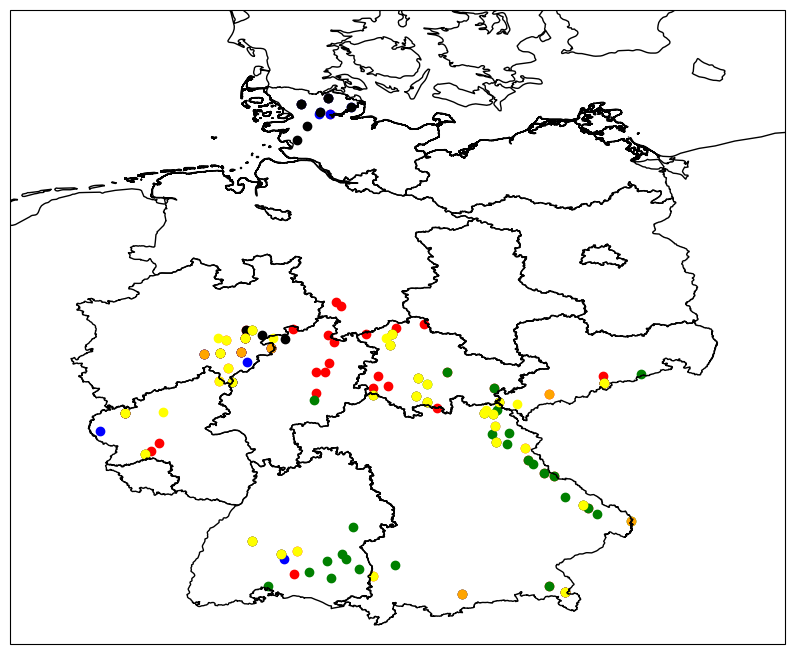

In [15]:
fig, ax = plotting.Germany_plot()
stat_locs = pd.read_csv('Saved_files/canm_latlon.csv')
for year_index, year in enumerate(stat_locs['Referenzjahr'].unique()):
    stat_locs_year = stat_locs.where(stat_locs['Referenzjahr'] == year).dropna()
    ax.scatter(stat_locs_year['lon'], stat_locs_year['lat'], label=year, color = ['r', 'g', 'b', 'k', 'purple', 'orange', 'yellow'][year_index])#, 'ro', transform=ccrs.PlateCarree())
stat_locs = stat_locs.where(stat_locs['Referenzjahr'] == 2004).dropna()
ax.scatter(stat_locs['lon'], stat_locs['lat'])#, 'ro', transform=ccrs.PlateCarree())

In [2]:
#ds = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2020.nc')
ds = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\Africa\\ERA5_SSA_2015.nc')
for year in range(2016, 2017):
    print(year)
    ds = xr.concat([ds, xr.open_dataset(f'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\Africa\\ERA5_SSA_{year}.nc')], dim='valid_time')
ds = ds.rename({'valid_time':'time', 'latitude':'lat', 'longitude':'lon'})
ds = ds.sortby('time')

2016


In [ ]:
ds_for_driver = xr.merge([d2m, t2m, ssrd, tp, t2max, t2min])
#ds_for_driver.to_netcdf('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2018_2024.nc')
#ds_for_driver = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2018_2024.nc')
ds_for_driver['t2m'] += -273.15
ds_for_driver['t2max'] += -273.15
ds_for_driver['t2min'] += -273.15
#ds_for_driver.to_netcdf('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land2_2001_2010.nc')
#ds.to_netcdf('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2018_2024.nc')
#ds3 = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2018_2024.nc')

In [ ]:
ds_for_driver['Averaging_Discrepancy'] = (ds_for_driver['t2max'] + ds_for_driver['t2min'])/2 - ds_for_driver['t2m']
diffs = ds_for_driver['Averaging_Discrepancy'].mean(dim='time')
diffs.plot()

In [ ]:
#ds = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2020.nc')
ds = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2001.nc')
for year in range(2002, 2025):
    print(year)
    ds = xr.concat([ds, xr.open_dataset(f'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\Germany_Pre_2000\\ERA5_land_{year}.nc')], dim='valid_time')
ds = ds.rename({'valid_time':'time', 'latitude':'lat', 'longitude':'lon'})
ds = ds.sortby('time')

In [ ]:
#ds = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2020.nc')
ds = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2001.nc')
for year in range(2002, 2025):
    print(year)
    ds = xr.concat([ds, xr.open_dataset(f'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_{year}.nc')], dim='valid_time')
ds = ds.rename({'valid_time':'time', 'latitude':'lat', 'longitude':'lon'})
ds = ds.sortby('time')

2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024


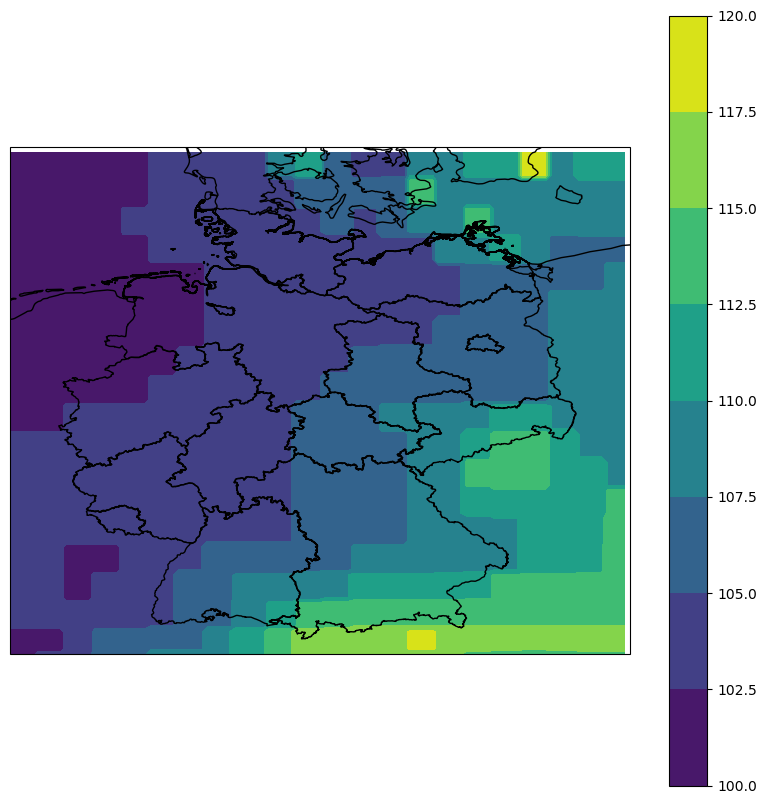

In [ ]:
lat = np.arange(47, 56, 0.1)
lon = np.arange(5, 16, 0.1)
LAT, LON = np.meshgrid(lat, lon)
SOS = np.maximum(dataset_fctns.WC_SOS(LON, LAT), 100)

fig, ax = plotting.Germany_plot()
cont = ax.contourf(LON, LAT, SOS, cmap='viridis', vmin  = 100, transform=ccrs.PlateCarree())
plt.colorbar(cont)